##TRANSFER LEARNING WITH TENSORFLOW PART 3 : SCALING UP (FOOD VISION MINI)

###CREATING HELPER FUNCTIONS

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-03 10:40:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-03 10:40:04 (79.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-08-03 10:40:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   221MB/s    in 6.4s    

2022-08-03 10:40:11 (244 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('/content/101_food_classes_10_percent.zip')

In [ ]:
train_dir = '101_food_classes_10_percent/train/'
test_dir ='101_food_classes_10_percent/test/'

In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images i

In [ ]:
# Setting Up Data Inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode='categorical',
                                                                              image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode='categorical',
                                                               image_size=IMG_SIZE,
                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##TRAINING A BIG DOG MODEL WITH TRANSFER LEARNING ON 10% OF 101 FOOD CLASSES

In [ ]:
# Creating Checkpoint Callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
# Creating Data Augmentation Layer To Incorporate It Right Into The Model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setting Up Data Augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.)
], name='DataAugmentation')

In [ ]:
# Setting Up The Base Model And Freezing Its Layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting Model Architecture With Trainable Top Layers
inputs = layers.Input(shape=(224, 224, 3), name='InputLayer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='GlobalAvgPoolLayer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='OutputLayer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAvgPoolLayer (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 OutputLayer (Dense)         (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 93s 322ms/step - loss: 3.4805 - accuracy: 0.2441 - val_loss: 2.6535 - val_accuracy: 0.4149
Epoch 2/5
237/237 [==============================] - 60s 250ms/step - loss: 2.3572 - accuracy: 0.4574 - val_loss: 2.2287 - val_accuracy: 0.4695
Epoch 3/5
237/237 [==============================] - 53s 223ms/step - loss: 1.9860 - accuracy: 0.5306 - val_loss: 2.0797 - val_accuracy: 0.4772
Epoch 4/5
237/237 [==============================] - 52s 218ms/step - loss: 1.7658 - accuracy: 0.5683 - val_loss: 1.9777 - val_accuracy: 0.4945
Epoch 5/5
237/237 [==============================] - 48s 200ms/step - loss: 1.6011 - accuracy: 0.6116 - val_loss: 1.9279 - val_accuracy: 0.5003


In [ ]:
# Evaluation On The Whole Test Dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7080 - accuracy: 0.5541


[1.7079508304595947, 0.5540593862533569]

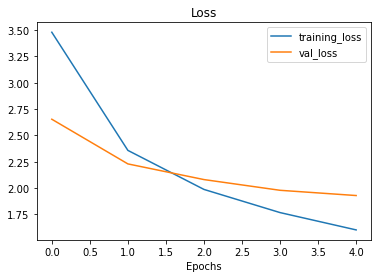

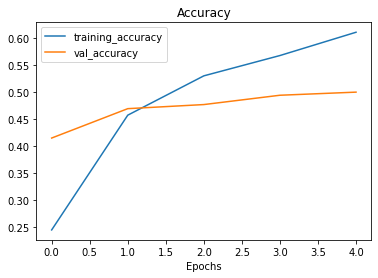

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

##FINE-TUNING

In [ ]:
# Unfreezing All Of The Layers In The Base Model
base_model.trainable = True

# Refreezing Every Layer Except The Last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompiling Model With Lower Learning Rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# What Layers In The Model Are Trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

InputLayer True
DataAugmentation True
efficientnetb0 True
GlobalAvgPoolLayer True
OutputLayer True


In [ ]:
# Checking Which Layers Are Trainable In Our Base Model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-Tuning For 5 More epochs
fine_tune_epochs = 10

# Fine-Tuning Our Model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 53s 195ms/step - loss: 1.3611 - accuracy: 0.6507 - val_loss: 1.9123 - val_accuracy: 0.5016
Epoch 6/10
237/237 [==============================] - 42s 175ms/step - loss: 1.2352 - accuracy: 0.6713 - val_loss: 1.8777 - val_accuracy: 0.5130
Epoch 7/10
237/237 [==============================] - 43s 181ms/step - loss: 1.1608 - accuracy: 0.6886 - val_loss: 1.9373 - val_accuracy: 0.5042
Epoch 8/10
237/237 [==============================] - 41s 172ms/step - loss: 1.0936 - accuracy: 0.7147 - val_loss: 1.9259 - val_accuracy: 0.5082
Epoch 9/10
237/237 [==============================] - 40s 167ms/step - loss: 1.0258 - accuracy: 0.7255 - val_loss: 1.8997 - val_accuracy: 0.5159
Epoch 10/10
237/237 [==============================] - 40s 167ms/step - loss: 0.9642 - accuracy: 0.7399 - val_loss: 1.8755 - val_accuracy: 0.5148


In [ ]:
# Evaluating On The Whole Test DataSet
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 58s 73ms/step - loss: 1.5982 - accuracy: 0.5795


[1.5981531143188477, 0.5795247554779053]

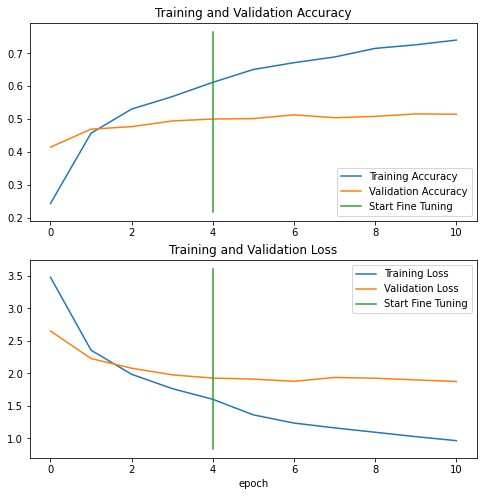

In [ ]:
# Comparing The Histories Of Feature Extraction Model With Fine-tuning Model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

##SAVING AND LOADING THE MODEL

In [ ]:
# Saving Our Fine-Tuning Model
model.save('/content/saved/101_food_classes_10_percent_saved_big_dog_model')

INFO:tensorflow:Assets written to: /content/saved/101_food_classes_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: /content/saved/101_food_classes_10_percent_saved_big_dog_model/assets


In [ ]:
# Loading A Saved Model
loaded_model = tf.keras.models.load_model('/content/saved/101_food_classes_10_percent_saved_big_dog_model')

In [ ]:
# Evaluating A Loaded Model
loaded_model_results = loaded_model.evaluate(test_data)


790/790 [==============================] - 59s 73ms/step - loss: 1.5982 - accuracy: 0.5795


In [ ]:
loaded_model_results

[1.5981531143188477, 0.5795247554779053]

In [ ]:
all_classes_10_percent_fine_tune_results

[1.5981531143188477, 0.5795247554779053]

##EVALUATING THE PERFORMANCE OF THE BIG DOG MODEL ACROSS ALL DIFFERENT CLASSES

In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-08-03 10:39:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c02::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   196MB/s    in 0.2s    

2022-08-03 10:39:34 (196 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
# Loading Saved Model
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
# Evaluating Loaded Model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 69s 73ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

###MAKING PREDICTIONS WITH OUR TRAINED MODEL

In [ ]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 61s 76ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
# First 10 Predictions
preds_probs[:10]

array([[5.9541997e-02, 3.5742044e-06, 4.1377008e-02, ..., 1.4138679e-09,
        8.3530824e-05, 3.0897509e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780820e-04, ..., 5.4287048e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866963e-03, ..., 7.1891270e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313246e-01, 1.2931228e-07, 1.4805609e-03, ..., 5.9750048e-04,
        6.6969005e-05, 2.3469245e-05],
       [4.4571832e-02, 4.7265476e-07, 1.2258517e-01, ..., 6.3498501e-06,
        7.5318512e-06, 3.6778776e-03],
       [7.2438955e-01, 1.9249771e-09, 5.2310937e-05, ..., 1.2291373e-03,
        1.5792714e-09, 9.6395648e-05]], dtype=float32)

In [ ]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
        8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
        1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
        6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
        1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
        8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
        2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
        8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
        3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
        8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
        3.5306122e-05, 3.2489035e-05, 6.7314730e

In [ ]:
print(f'Number Of Prediction Probabilities For Sample 0: {len(preds_probs[0])}')
print(f'What Prediction Probability Sample 0 Looks Like:\n {preds_probs[0]}')
print(f'The Class With The Highest Predicted Probabiliy By The Model For Sample 0: {preds_probs[0].argmax()}')

Number Of Prediction Probabilities For Sample 0: 101
What Prediction Probability Sample 0 Looks Like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.

In [ ]:
# Getting The pred Classes of Each Label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# To Get Our Test Labels We Need To Unravel Our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

##EVALUATING OUR MODEL'S PREDICTIONS

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Scikit-Learn's Accuracy Score Functions
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

##CREATING CONFUSION MATRIX

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

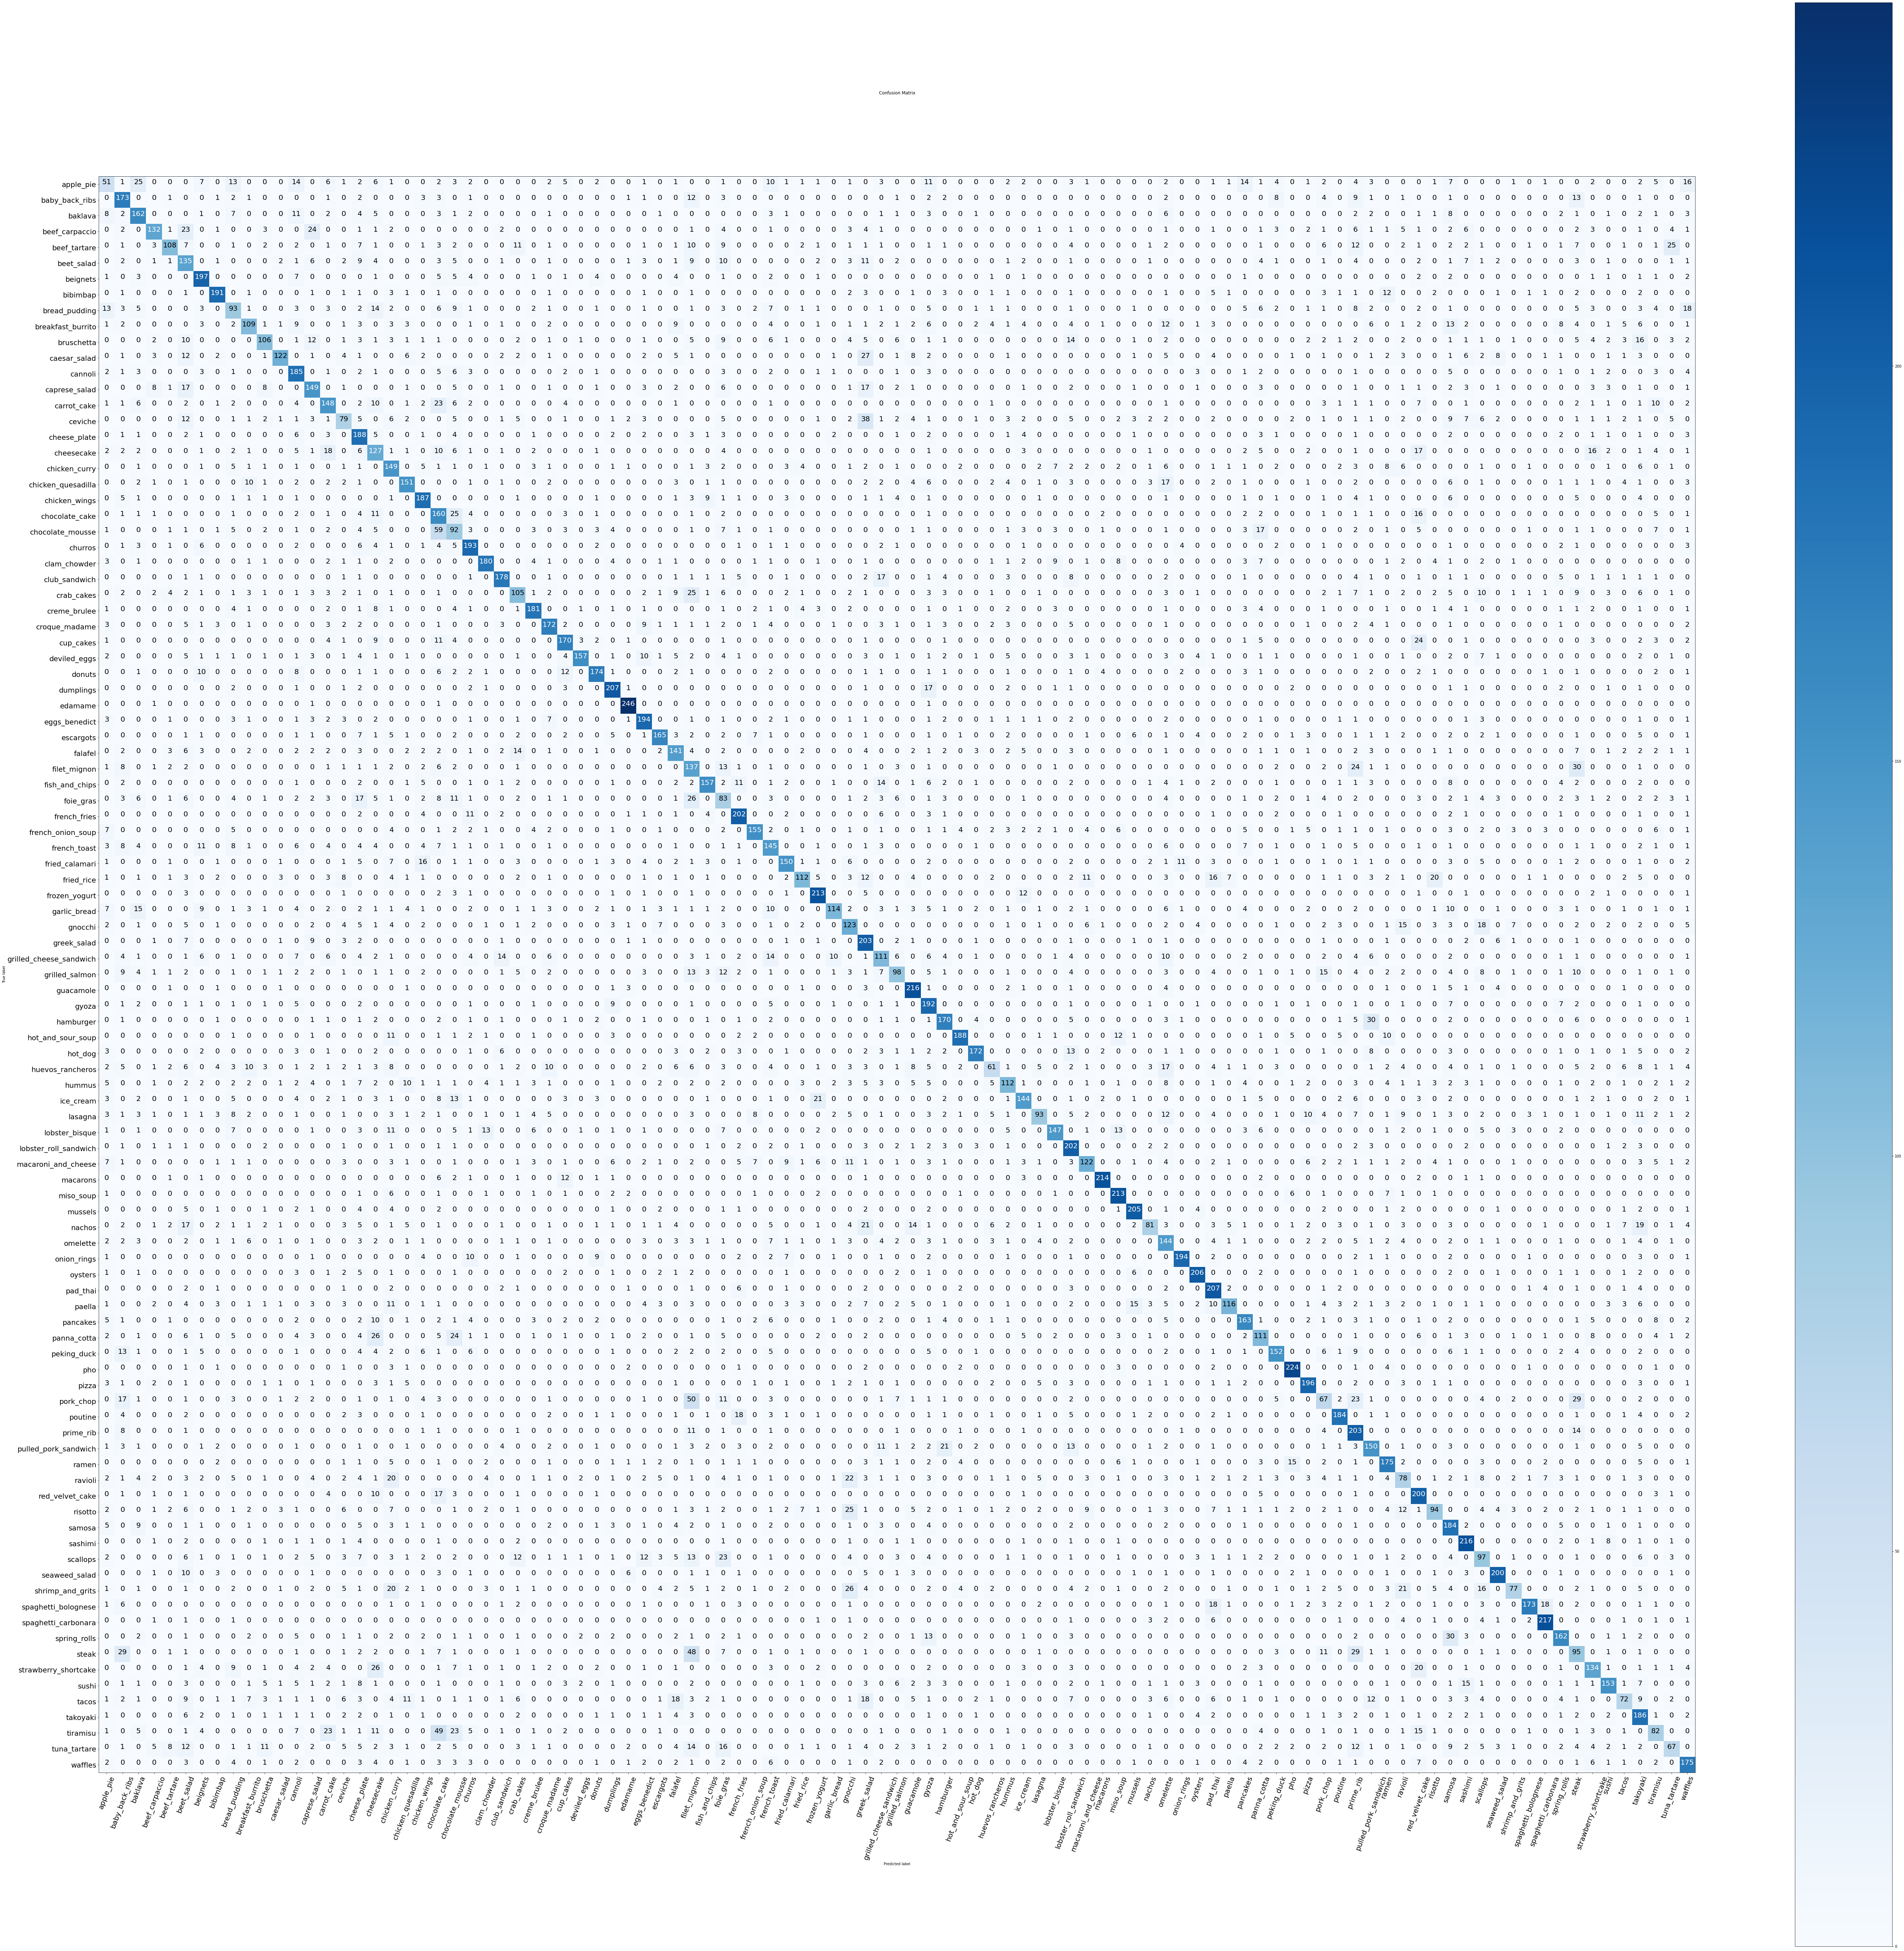

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

##CLASSIFICATION REPORT

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Getting A Dictionary Of The Classification Report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

PLOTTING ALL OF OUR CLASSES F1-SCORES

In [ ]:
# Creating Empty Dictionary
class_f1_scores = {}

# Looping Through Classification Report Dictionary Items
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# turn f1-scores Into DataFrame For Visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [ ]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

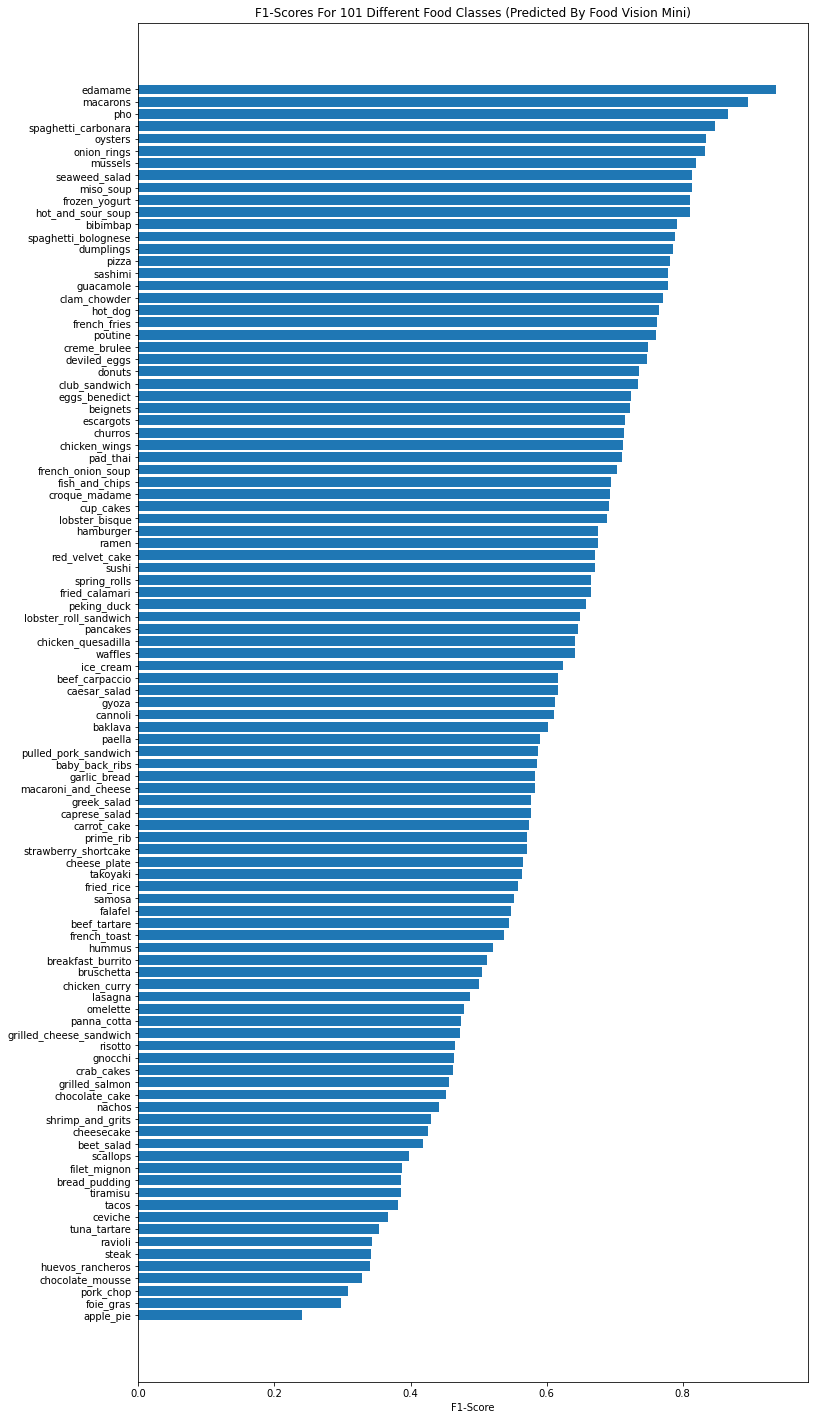

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-Score')
ax.set_title('F1-Scores For 101 Different Food Classes (Predicted By Food Vision Mini)')
ax.invert_yaxis();

##VISUALIZING PREDICTIONS ON CUSTOM IMAGES

CREATING A FUNCTION TO LOAD AND PREPARE IMAGE

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads In An Image From Filename, Turns It Into A tensor And Reshapes Into
  Specified Shape (img_shape, imag_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image-shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-225 to 0-1 or not
  
  Returns:
  Image Tensor Of Shape (img_shape, img_shape, 3)
  """
  # Read In The Image 
  img = tf.io.read_file(filename)

  # Decode Image Into Tensor
  img = tf.io.decode_image(img, channels=3)

  # Resizing The Image
  img = tf.image.resize(img, [img_shape, img_shape])

  # scale? Yes/No
  if scale:
    return img/255.
  else:
    return img

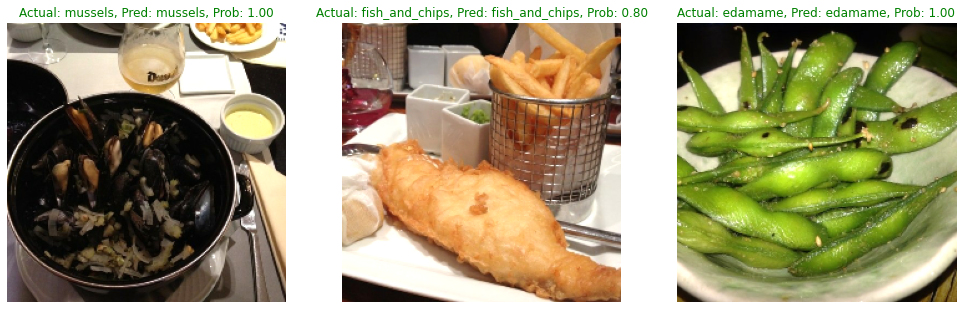

In [ ]:
# Making preds On A Series Of Random Images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename
  
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plotting The Image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/225.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

##FINDING THE MOST WRONG PREDICTIONS

In [ ]:
# Getting All Of The Image File Paths In The Test Dataset
filepaths = []
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# Creating A DataFrame Of Different Parameters For Each Of Our Test Images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# Finding Out Which Predictions Are Wrong In Our DataFrame
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [ ]:
# Sorting Our DataFrame To Have Most Wrong Predictions At The Top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

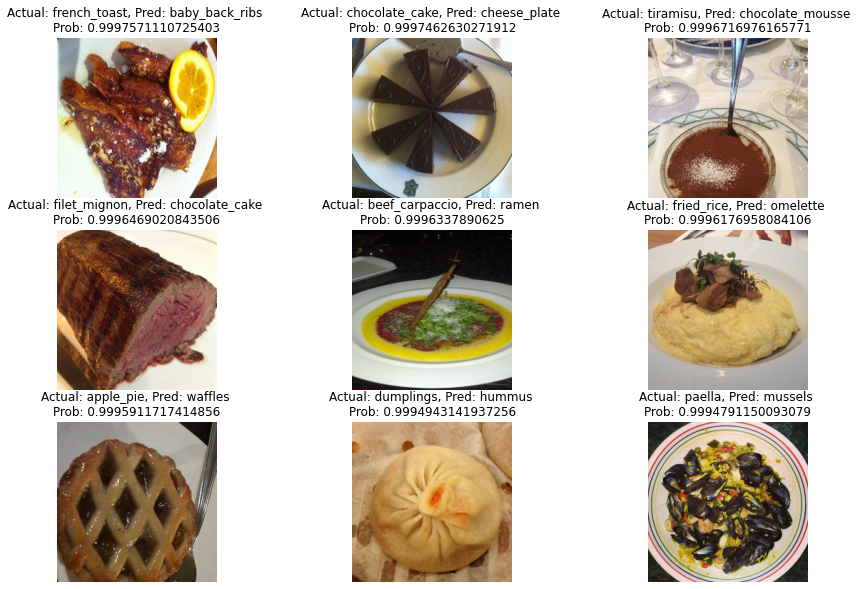

In [ ]:
# Visualizing The Test Data Samples Which Have The Wrong Prediction But Highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f'Actual: {y_true_classname}, Pred: {y_pred_classname} \nProb: {pred_prob}')
  plt.axis(False);


## Testing Out The Big Dog Model On Our Own Custom Images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-08-03 12:27:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  43.1MB/s    in 0.3s    

2022-08-03 12:27:52 (43.1 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data('/content/custom_food_images.zip')

In [ ]:
# Getting Custom Images Filepaths
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg']

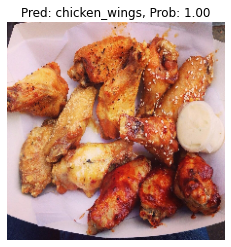

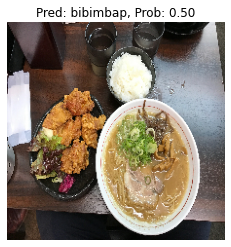

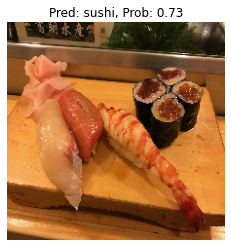

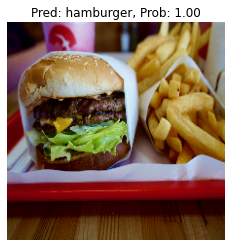

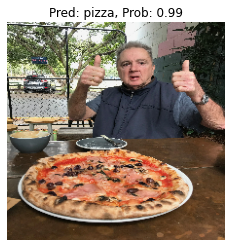

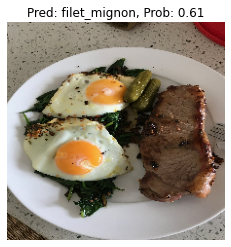

In [ ]:
# Make Predictions On And Plot Custom Images 
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'Pred: {pred_class}, Prob: {pred_prob.max():.2f}')
  plt.axis(False);